In [18]:
import pandas as pd
import numpy as np
import sklearn

import matplotlib 
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import average_precision_score

from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import Imputer

import time
from operator import itemgetter

import copy
from copy import deepcopy
print_mode = True

In [19]:
%run import_data


In [20]:
base = copy.deepcopy(merged_data)

colonnes_inutiles = ['num_veh','Num_Acc',
                                'locp',
                                'actp',
                                'etatp',
                                'catv',
                                'hrmn',
                                'mois',
                                'jour',
                                'catvopp',
                                'occutc',
                                'place']
merged_data = merged_data.drop(colonnes_inutiles,axis = 1)



In [21]:
target = merged_data.grav
target_binaire = target.replace([3,4],0)
target_binaire = target_binaire.replace(2,1)


merged_data = merged_data.drop('grav',axis = 1)
colnames = list(merged_data.columns)
colnames.remove('an_nais')
data_cat = merged_data[colnames]
data_cat = data_cat.astype(str)



X_cat = np.copy(data_cat) 
for col_id in range(len(X_cat[0])):
    unique_val, val_idx = np.unique(X_cat[:, col_id], return_inverse=True) 
    X_cat[:, col_id] = val_idx

imp_cat = Imputer(missing_values=np.nan, strategy='most_frequent') 
X_cat[:, range(5)] = imp_cat.fit_transform(X_cat[:, range(5)])


encodeur = OneHotEncoder()
encodeur.fit(X_cat)
X_cat = encodeur.transform(X_cat).toarray()

In [22]:
lol = pd.DataFrame(target)

In [23]:
colnames = list(merged_data.columns)
colnames.remove('an_nais')

In [24]:
lol.shape

(32417, 1)

In [25]:
X_cat = pd.get_dummies(data_cat, columns = colnames)
X_cat = X_cat.astype(int)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_cat, 
                                                    target, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [27]:
def TP(theta,pred,result):
    count = 0
    i = 0
    for x in (result):
        if pred[i][1] > theta and x == 1:
            count += 1
        i += 1
    return count


def FP(theta,pred,result):
    count = 0
    i = 0
    for x in (result):
        if pred[i][1] >= theta and x == 0:
            count += 1
        i += 1
    return count


def TN(theta,pred,result):
    count = 0
    i = 0
    for x in (result):
        if pred[i][1] < theta and x == 0:
            count += 1
        i += 1
    return count


def FN(theta,pred,result):
    count = 0
    i = 0
    for x in (result):
        if pred[i][1] < theta and x == 1:
            count += 1
        i += 1
    return count


class ROC_curves:
    def __init__(self,
                 pred=merged_data,
                 res=target,
                 gran = 101):
        x = []
        y = []
        for j in range(0,gran):
            tn = TN(j/(gran-1),pred,res)
            neg = tn + FP(j/(gran-1),pred,res)
            tp = TP(j/(gran-1),pred,res)
            pos = tp + FN(j/(gran-1),pred,res)

            if neg == 0:
                x.append(0)
            else:
                x.append(tn / neg)
            if pos == 0:
                y.append(0)
            else:
                y.append(tp / pos)
      
        self.rocx = x
        self.rocy = y
    def plot_it(self):
        plt.plot(self.rocx,self.rocy)
        plt.show()

In [28]:
class Qualite:
    def __init__(self, 
                   _modele, 
                   _data=merged_data, 
                   _y=target, 
                   _y_pred=target,
                   _y_pred_proba=target,
                   _cv=10,
                   _print_mode=True):
        
        self.accuracy = sklearn.metrics.accuracy_score(_y, _y_pred)
        self.AUC = sklearn.metrics.roc_auc_score(_y, _y_pred)
        self.cross_validation = cross_val_score(_modele, _data, y=_y, cv=_cv)
        self.moyenne = np.mean(self.cross_validation)
        self.ecart_type = np.std(self.cross_validation)
        self.precision = average_precision_score(_y, _y_pred)
        
        self.roc = ROC_curves(pred=_y_pred_proba, res=_y)
        
        
        if _print_mode:
            self.roc.plot_it()

In [29]:
def algo_apprentissage(mod=GaussianNB(),
                           data=merged_data,
                           target=target_binaire,
                           print_mode=True,
                           cv=10):
    X_train, X_test, y_train, y_test = train_test_split(data, 
                                                    target, 
                                                    test_size=0.2, 
                                                    random_state=42)
    result = dict()
    mod_fit = mod.fit(X_train, y_train)
    y_prediction_proba = mod_fit.predict_proba(X_test)
    y_prediction = mod_fit.predict(X_test)
    q_mod = Qualite(_modele=mod,
                 _data=X_test,
                 _y=y_test,
                 _y_pred=y_prediction,
                 _y_pred_proba=y_prediction_proba,
                 _print_mode=print_mode,
                 _cv=cv)
    
    result['y_prediction_proba'] = y_prediction_proba
    result['y_prediction'] = y_prediction
    result['q_mod'] = q_mod
    
    if print_mode:
        print('La précision est ' + str(q_mod.accuracy))
        print('')
        print('L\'AUC est ' + str(q_mod.AUC))
        print('')
        print('Le score moyen par ' + str(cv) + ' cross-validation est ' + str(q_mod.moyenne))
    
    return result

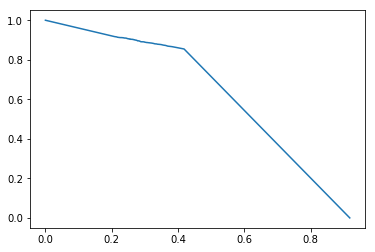

La précision est 0.530999383097

L'AUC est 0.584926585695

Le score moyen par 10 cross-validation est 0.536545304937


{'q_mod': <__main__.Qualite at 0x103b98b38>,
 'y_prediction': array([1, 1, 1, ..., 0, 0, 1]),
 'y_prediction_proba': array([[  1.17422940e-51,   1.00000000e+00],
        [  8.68635910e-10,   9.99999999e-01],
        [  5.67179015e-10,   9.99999999e-01],
        ..., 
        [  9.90314647e-01,   9.68535275e-03],
        [  1.00000000e+00,   3.05520454e-14],
        [  9.33161795e-15,   1.00000000e+00]])}

In [30]:
algo_apprentissage(data=X_cat, target=target_binaire)

In [31]:
set(target_binaire)

{0, 1}

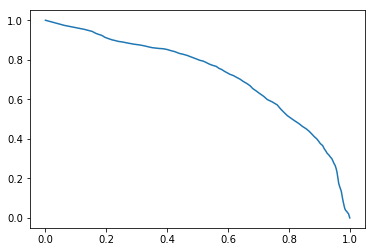

La précision est 0.670727945713

L'AUC est 0.670316778796

Le score moyen par 10 cross-validation est 0.637564490203


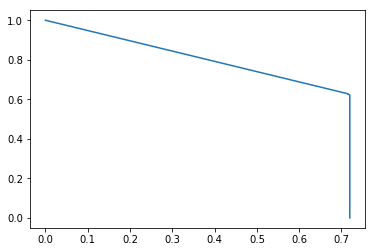

La précision est 0.679056138186

L'AUC est 0.670820171577

Le score moyen par 10 cross-validation est 0.678612491059


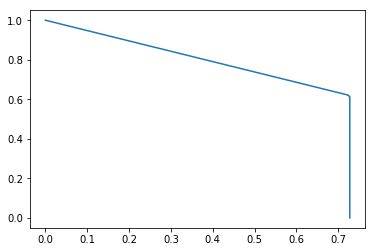

La précision est 0.680598396052

L'AUC est 0.670945505306

Le score moyen par 10 cross-validation est 0.680610806779


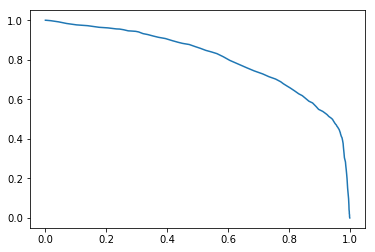

La précision est 0.75493522517

L'AUC est 0.729681359327

Le score moyen par 10 cross-validation est 0.75278313138


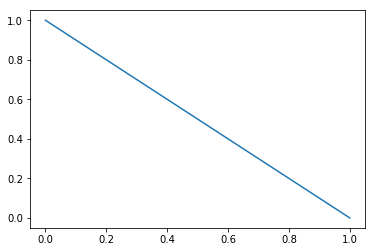

La précision est 0.585286859963

L'AUC est 0.5

Le score moyen par 10 cross-validation est 0.572786759202


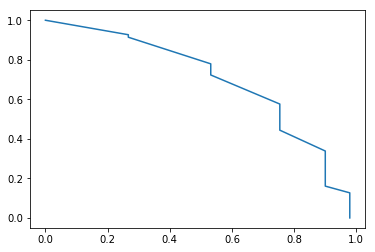

La précision est 0.680135718692

L'AUC est 0.66496863472

Le score moyen par 10 cross-validation est 0.655148066898


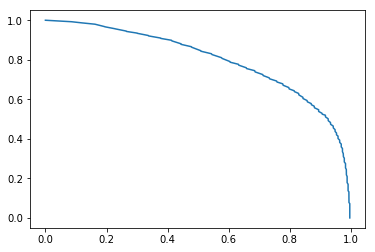

La précision est 0.746298581123

L'AUC est 0.729456366174

Le score moyen par 10 cross-validation est 0.742762261408


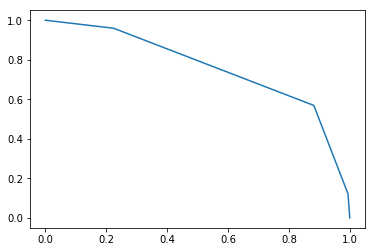

La précision est 0.752159161012

L'AUC est 0.72546734341

Le score moyen par 10 cross-validation est 0.746306878179


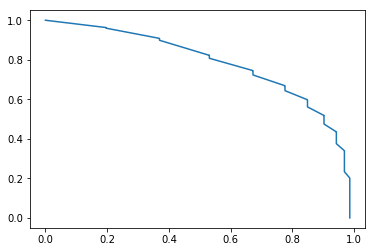

La précision est 0.744447871684

L'AUC est 0.723160771621

Le score moyen par 10 cross-validation est 0.738130484383


In [32]:
GNB = GaussianNB()
gnb = algo_apprentissage(GNB)

DTC = tree.DecisionTreeClassifier()
dtc = algo_apprentissage(DTC)

ID3 = tree.DecisionTreeClassifier(criterion="entropy")
id3 = algo_apprentissage(ID3)

decision_stump = GradientBoostingClassifier(n_estimators=100,
                                 learning_rate=1.0,
                                 max_depth=1,
                                 random_state=0)
ds = algo_apprentissage(decision_stump)

MLP = MLPClassifier(solver='lbfgs',
                    alpha=1,
                    hidden_layer_sizes=(20, 10))
mlp = algo_apprentissage(MLP)

KNN = KNeighborsClassifier()
knn = algo_apprentissage(KNN)

BC = BaggingClassifier(n_estimators=50)
bc = algo_apprentissage(BC)

ABC = AdaBoostClassifier(n_estimators=50,
                         learning_rate=1.0,
                         algorithm='SAMME.R',
                         random_state=None)
abc = algo_apprentissage(ABC)

RFC = RandomForestClassifier(n_estimators=10,
                             criterion='gini',
                             max_depth=None,
                             min_samples_split=2,
                             min_samples_leaf=1,
                             min_weight_fraction_leaf=0.0,
                             max_features='auto',
                             max_leaf_nodes=None,
                             min_impurity_decrease=0.0,
                             min_impurity_split=None,
                             bootstrap=True,
                             oob_score=False,
                             n_jobs=1,
                             random_state=None,
                             verbose=0,
                             warm_start=False,
                             class_weight=None)
rfc = algo_apprentissage(RFC)



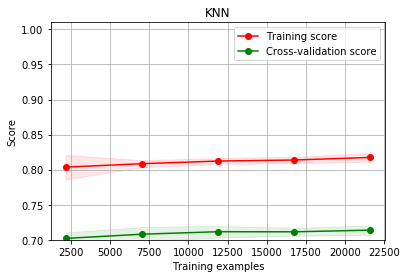

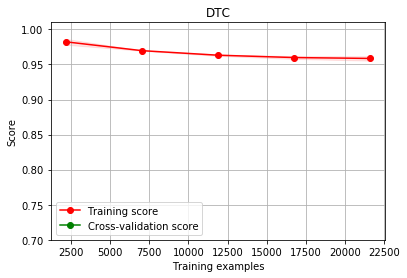

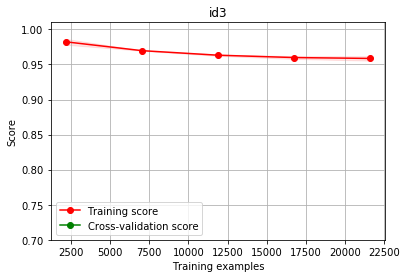

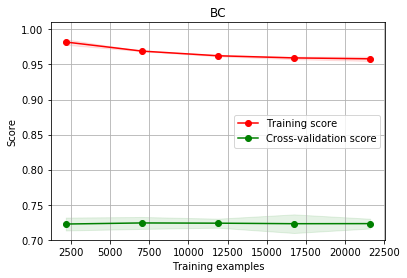

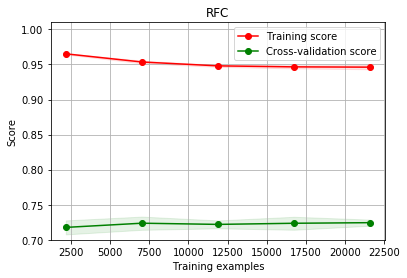

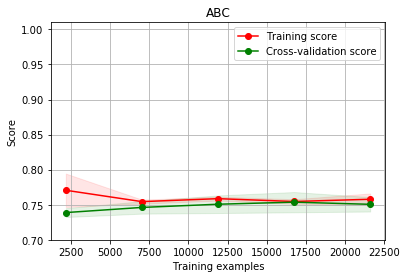

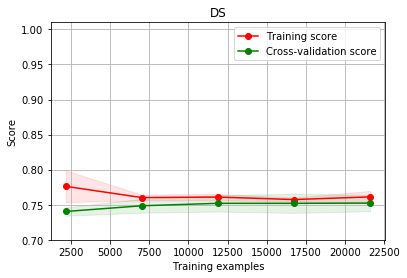

NameError: name 'pca_transform' is not defined

In [47]:
colnames = ['Accuracy', 'AUC', 'Moyenne CV', 'Std CV', 'Temps']
algos = [KNN, DTC, ID3, BC, RFC, ABC, decision_stump]
indexs = ['KNN', 'DTC', 'id3', 'BC', 'RFC', 'ABC', 'DS']
clfs = dict()
for x in range(len(algos)):
    clfs[indexs[x]] = algos[x]
    plot_learning_curve(estimator=algos[x], title=indexs[x], X=X_cat, y=target_binaire)
    
    
    
def final_table(mode=None,
                data=merged_data,
                target=target_binaire,
                col=colnames,
                algos=algos,
                indexs=indexs):
    if mode is None:
        pass
    elif mode == 'normalized':
        scaler = StandardScaler()
        scaler.fit(data)
        data = scaler.transform(data)
    elif mode == 'min_max_ed':
        scaler = MinMaxScaler()
        scaler.fit(data)
        data = scaler.transform(data)
    elif mode == 'pca':
        data = pca_transform(data=data,
                                 normalized=True,
                                 print_mode=False)[1]


    result = []
    for alg in algos:
        t1 = time.time()
        res_algo = algo_apprentissage(alg, data=data, target=target,print_mode=False)
        t2 = time.time()
        delta_t = t2 - t1
        ajout = [res_algo['q_mod'].accuracy, res_algo['q_mod'].AUC, res_algo['q_mod'].moyenne, res_algo['q_mod'].ecart_type, delta_t]
        result.append(ajout)

    result = pd.DataFrame(result, columns=colnames, index=indexs)
    return result

modes = [None, 'normalized', 'min_max_ed', 'pca']

tables = dict()
for mode in modes:
    event = dict()
    tables[str(mode)] = final_table(mode=mode)

In [ ]:
tables['None']

In [ ]:
base.columns

In [ ]:
correlations = base.corr()
# plot correlation matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,9,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(list(base.columns))
ax.set_yticklabels(list(base.columns))
plt.show()

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cvalidation=None,
                        n_jobs=4, train_sizes=np.linspace(.1, 1.0, 5), print_mode=True):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cvalidation : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cvalidation, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    if print_mode:
        plt.show()
    return plt


digits = load_digits()
X, y = digits.data, digits.target


title = "Learning Curves (Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cvalidation = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = KNN
##plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cvalidation=cvalidation, n_jobs=4)




In [35]:
cv

ShuffleSplit(n_splits=10, random_state=0, test_size=0.2, train_size=None)

In [38]:
type(cv)

sklearn.model_selection._split.ShuffleSplit

In [48]:
list(base.columns)

['Num_Acc',
 'place',
 'catu',
 'grav',
 'sexe',
 'secu',
 'locp',
 'actp',
 'etatp',
 'an_nais',
 'num_veh',
 'senc',
 'catv',
 'occutc',
 'obs',
 'obsm',
 'choc',
 'manv',
 'mois',
 'jour',
 'hrmn',
 'lum',
 'agg',
 'int',
 'atm',
 'col',
 'mom',
 'catvopp',
 'catv_gen',
 'catvopp_gen']